In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from typing import List

# 1. Compute Indicator and Export

In [2]:
DROP_COLS: List[str] = [
    'faixa', 
    'accelerationlight',	
    'accelerationheavy',	
    'accelerationothers',
    'confidence_avg',
    'confidence_min_interval',
    'confidence_max_interval',
    'heading',
    'zoom'
]

VELOCITY_COLS: List[str] = [
    'speedlight', 
    'speedheavy', 
    'speedothers'
]

COUNTABLE_COLS: List[str] = [
    'vehiclelight',
    'vehicleheavy',
    'vehicleothers',
    'class_count'
]

In [3]:
def arrange_timestamps(data: pd.DataFrame) -> pd.DataFrame:
    clean_data: pd.DataFrame = pd.DataFrame()

    for post in data['n_p'].unique():
        # extract post dataframe with time_index as columns
        post_df: pd.DataFrame = data[data['n_p'] == post]
        post_df: pd.DataFrame = post_df.reset_index()
        
        # build baseline series of timestamps
        timestamps: pd.DataFrame = pd.date_range(data.index.min(), data.index.max(), freq='15min').to_frame()
        timestamps.columns: List[str] = ['time_index']
        timestamps['n_p']: pd.Series = post
        
        # join post with baseline series (results in more NaN fields)
        temp: pd.DataFrame = timestamps.merge(post_df, on=['n_p', 'time_index'], how='left')
        
        # append to final df
        clean_data: pd.DataFrame = pd.concat([clean_data, temp])
        
    return clean_data

In [4]:
def clean(data: pd.DataFrame) -> pd.DataFrame:
    # 1. remove unused columns
    data: pd.DataFrame = data.drop(DROP_COLS, axis=1)

    # 2. convert average velocity from m/s to km/h for better comprehension
    #   convert m to km by dividing the meters by 1000
    #   convert the seconds to hours we divide the hours by 3600
    #   3600/1000 = 18/5 = 3.6
    data[VELOCITY_COLS]: pd.DataFrame = data[VELOCITY_COLS] * 3.6

    # 3. missing values in time (33 days * 24 hours * 4 intervals of 15min = 3168)
    #    3168 * 3 posts = 9504 but lenght of data is 9258
    data: pd.DataFrame = arrange_timestamps(data)
    
    # 4. sort by n_p and time_index to assure order
    data: pd.DataFrame = data.sort_values(by=['n_p', 'time_index'])
    
    # 5. set time_index as df index
    data: pd.DataFrame = data.set_index('time_index')

    assert len(data) == 9504, 'Missmatch Error: data lenght should be 9504 (33*24*4*3)'
    
    return data

In [5]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame:
    # 1. inputation of NaNs
    
    # rolling windows of the last hour
    data: pd.DataFrame = data.fillna(data.rolling(window=4, min_periods=1).mean())
    
    # if not possible (there are no values recorded for a while) to average, then 0
    data: pd.DataFrame = data.fillna(0)
    
    # 2. round columns that should be int
    data[COUNTABLE_COLS]: pd.DataFrame = round(data[COUNTABLE_COLS])
    data[COUNTABLE_COLS]: pd.DataFrame = data[COUNTABLE_COLS].astype(int)
    
    return data

In [6]:
def compute_indicator(data: pd.DataFrame) -> pd.DataFrame:
    # min-max norm to avoid giving different importance to different features
    data_transformed: pd.DataFrame = data.drop(['n_p'], axis=1)
    data_transformed: np.ndarray = MinMaxScaler().fit_transform(data_transformed)

    # PCA to reduce 7 dimensions to single indicator
    mobility: np.ndarray = PCA(n_components=1).fit_transform(data_transformed)

    # add to final df
    data['indicator']: pd.Series = mobility
    
    return data

In [7]:
# read
data: pd.DataFrame = pd.read_parquet('s3://datalake-eu-central-1/ugiO-atchackathon/preprocessed/aggregated.parquet')

In [8]:
# clean
data: pd.DataFrame = clean(data)

In [9]:
# preprocessing
data: pd.DataFrame = preprocess(data)

In [10]:
# modeling
data: pd.DataFrame = compute_indicator(data)

In [11]:
# export
data.to_parquet('s3://datalake-eu-central-1/ugiO-atchackathon/preprocessed/indicator.parquet')

# 2. Visualization

In [12]:
def print_series_of_post(data: pd.DataFrame, post_id: str) -> None:
    series: List[str] = list(data.select_dtypes(include=['float', 'int']).columns)
    
    temp: pd.DataFrame = data[data['n_p'] == post_id]
    temp: pd.DataFrame = temp.reset_index()
    
    for serie in series:
        temp.plot.line(x='time_index', y=serie, title= post_id + '_' + serie, figsize=(20, 10))
        plt.show()

In [8]:
data: pd.DataFrame = pd.read_parquet('s3://datalake-eu-central-1/ugiO-atchackathon/preprocessed/indicator.parquet')

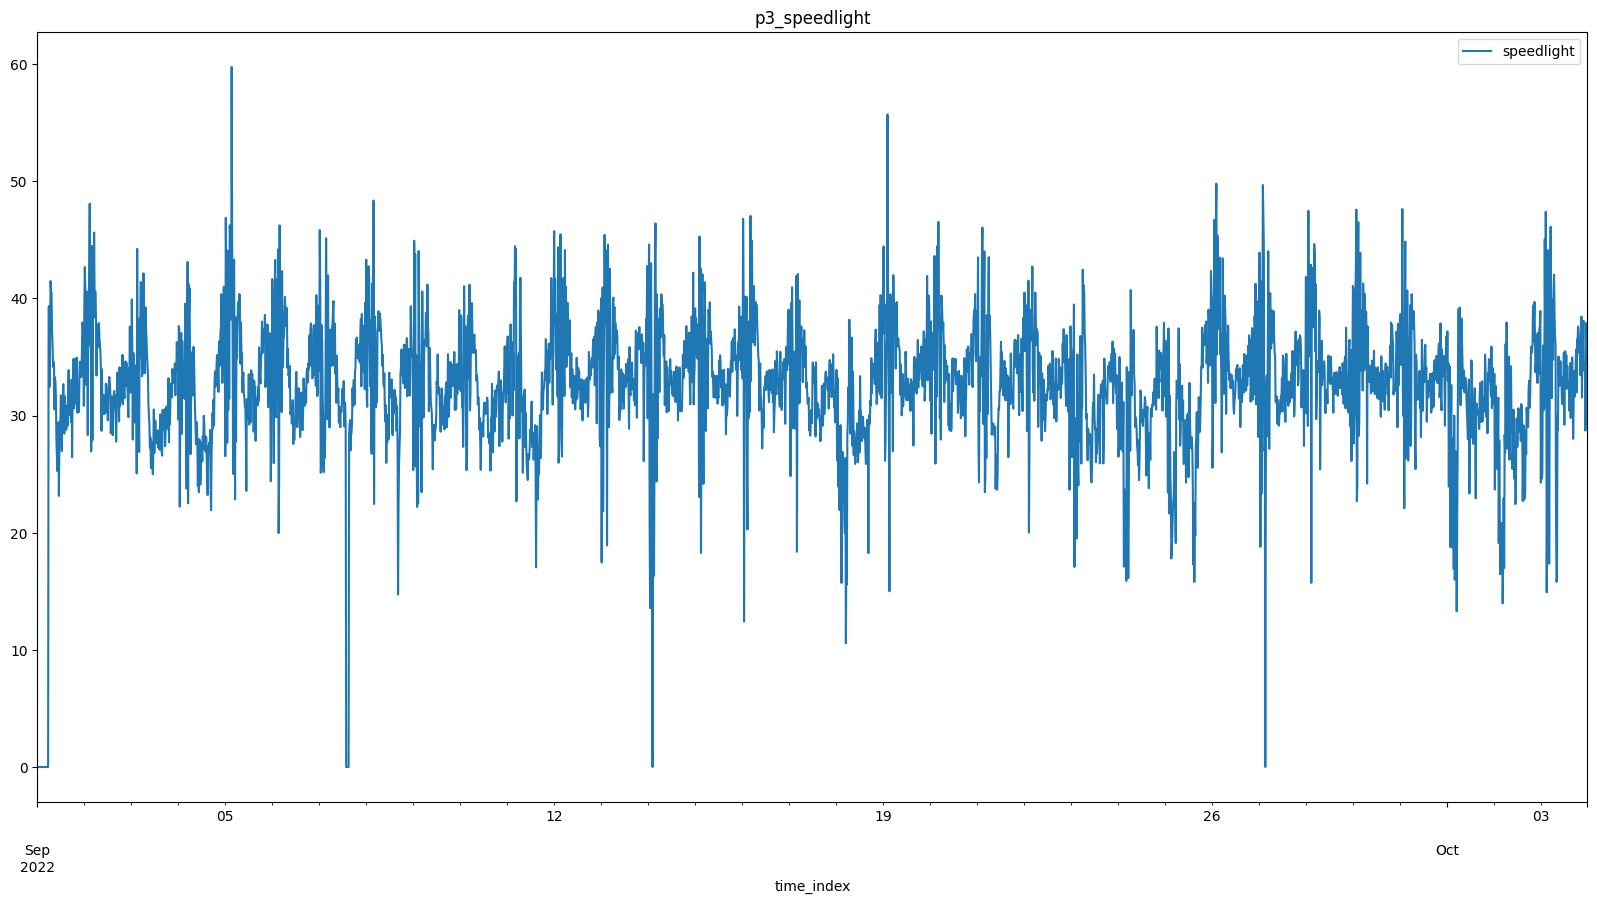

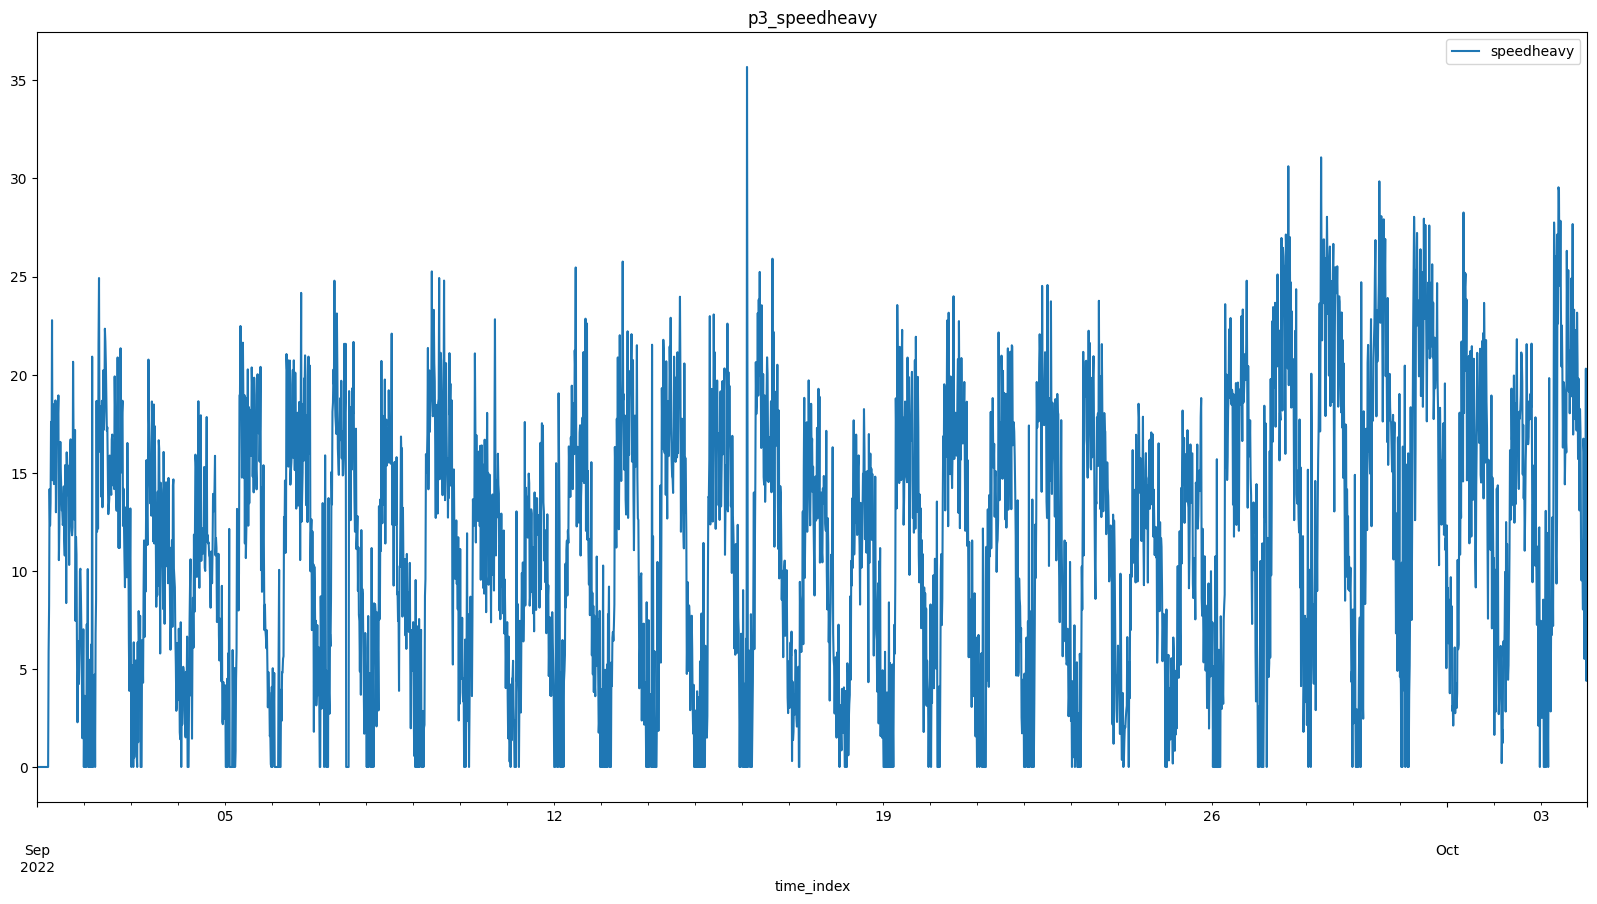

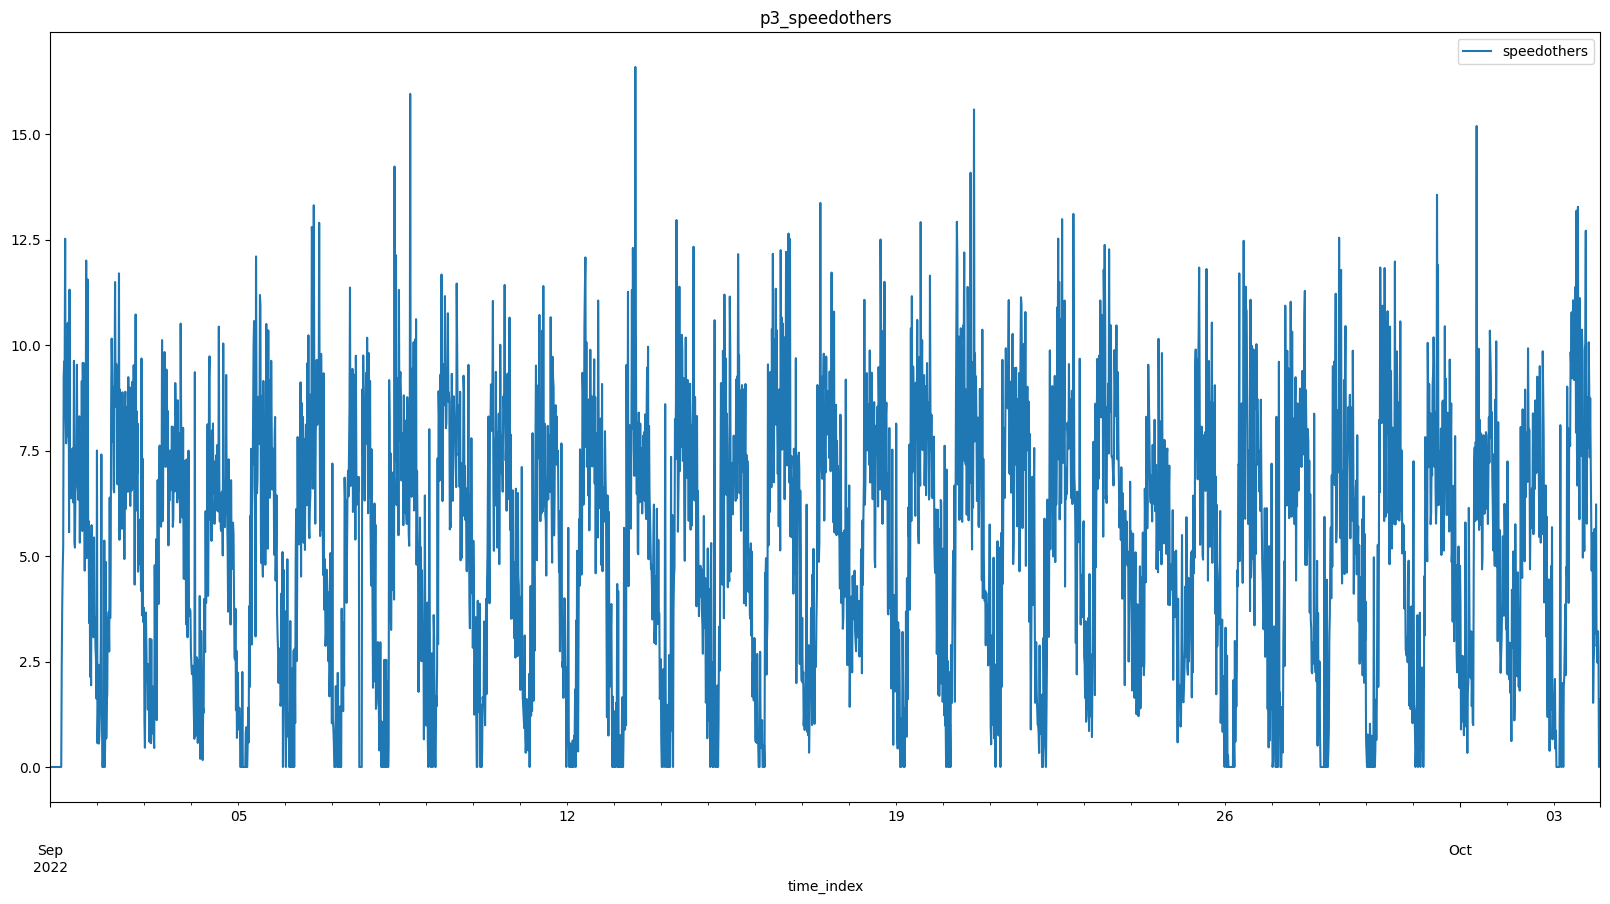

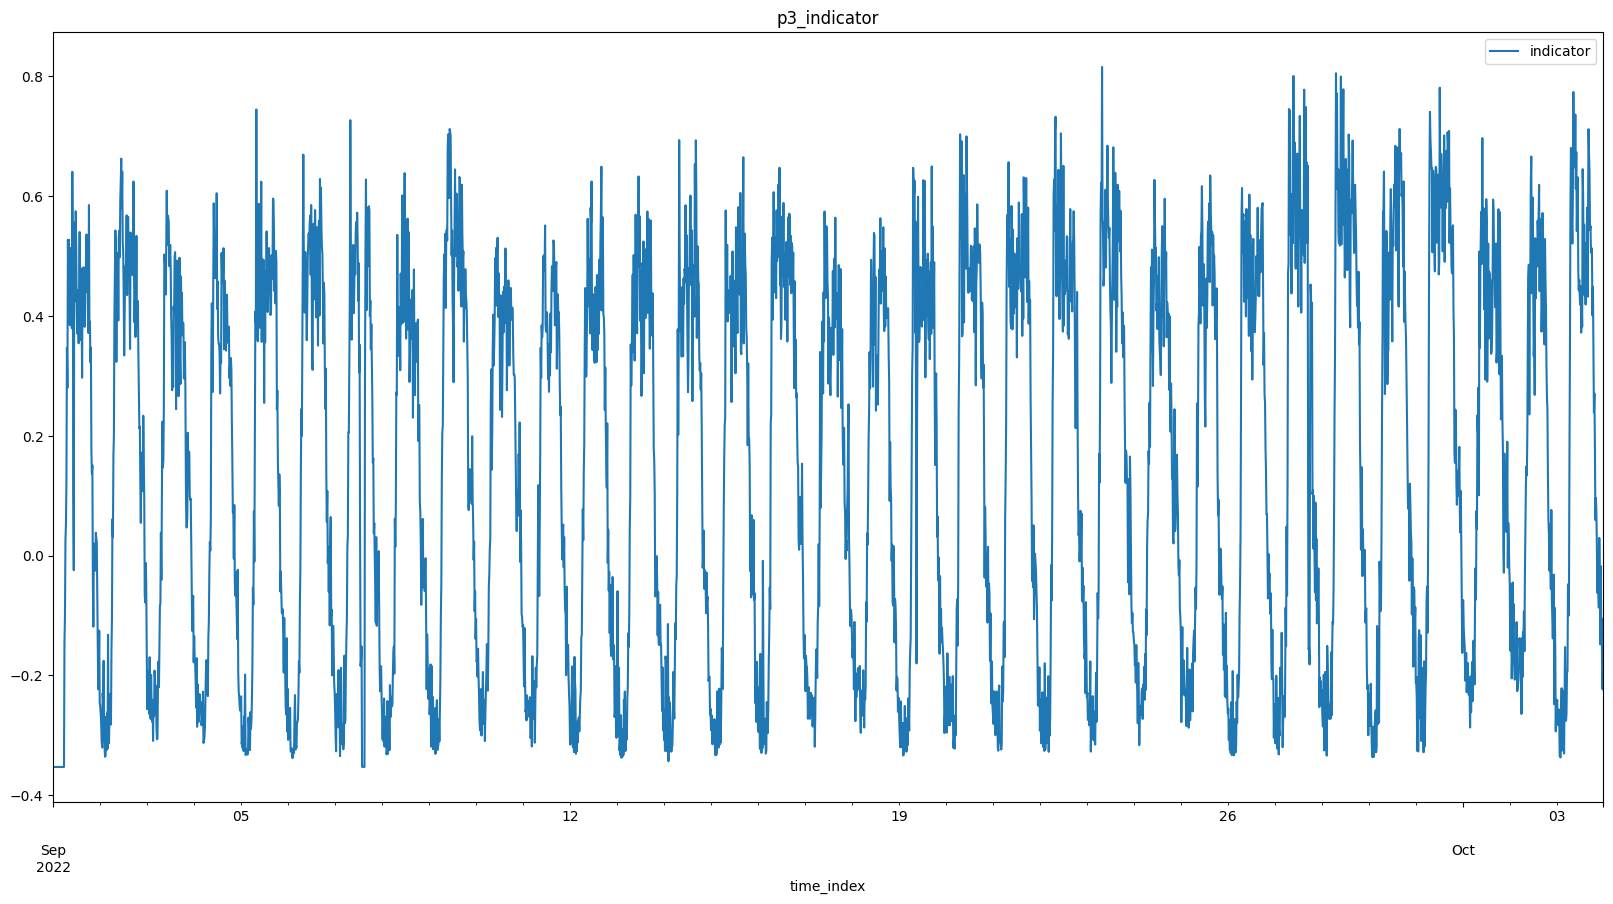

In [14]:
# p1, p3, p35
print_series_of_post(data, 'p3')

# 3. Additional EDA

In [16]:
data: pd.DataFrame = pd.read_parquet('../../databases/indicator.parquet')

In [25]:
numeric_cols: List[str] = data.select_dtypes(include=['float', 'int']).columns
temp: pd.DataFrame = data[data[numeric_cols] > 0]

In [42]:
temp.quantile([0.25, 0.75])

,vehiclelight,speedlight,vehicleheavy,speedheavy,vehicleothers,speedothers,class_count,indicator
0.25,18.0,32.736405,2.0,4.430618,3.0,3.695766,2.0,0.283119
0.75,192.0,41.285437,23.0,16.440083,47.0,12.377852,14.0,0.545926


array([[<AxesSubplot:title={'center':'vehiclelight'}>,
        <AxesSubplot:title={'center':'speedlight'}>,
        <AxesSubplot:title={'center':'vehicleheavy'}>],
       [<AxesSubplot:title={'center':'speedheavy'}>,
        <AxesSubplot:title={'center':'vehicleothers'}>,
        <AxesSubplot:title={'center':'speedothers'}>],
       [<AxesSubplot:title={'center':'class_count'}>,
        <AxesSubplot:title={'center':'indicator'}>, <AxesSubplot:>]],
      dtype=object)

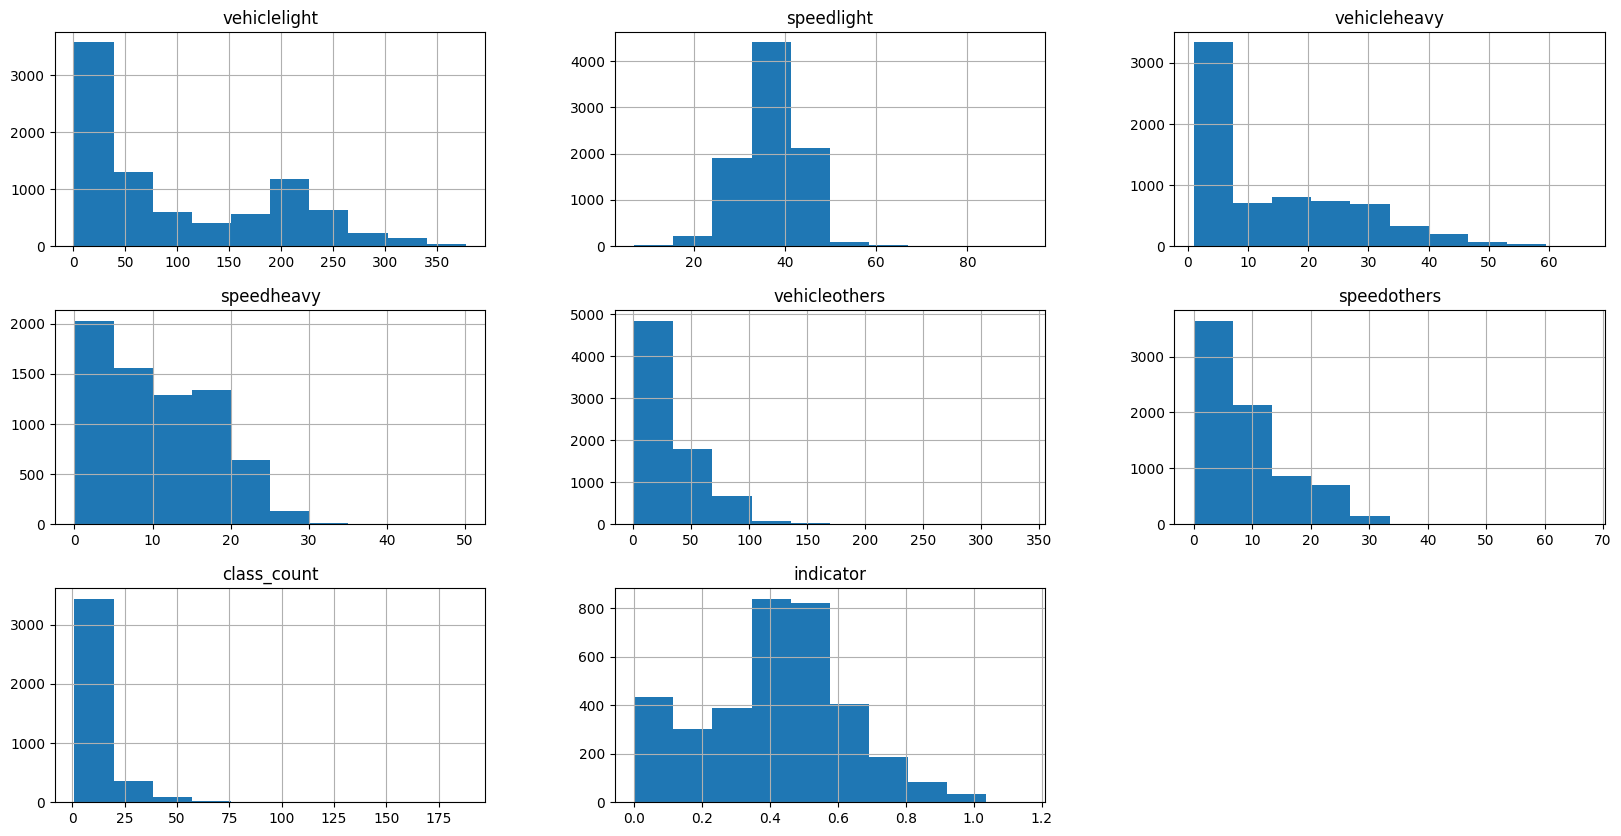

In [27]:
temp.hist(figsize=(20,10))